In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

rawdata = pd.read_csv('https://raw.githubusercontent.com/yuezheli/BankChurnerPred/main/BankChurners.csv', header = 0)


# label existing customers as 0
rawdata.replace('Existing Customer', 0, regex=True, inplace = True)
# label attrited customers as 1
rawdata.replace('Attrited Customer', 1, regex=True, inplace = True)


# drop unnecessary categorical variables

rawdata.drop(['CLIENTNUM', 'Education_Level', 'Marital_Status', 'Income_Category',
              'Card_Category'], axis = 1, inplace = True)

# binary encode of gender
rawdata.replace('M', 0, regex=True, inplace = True) # male = 0
rawdata.replace('F', 1, regex=True, inplace = True) # female = 0

# drop more unrelated variable
rawdata.drop(['Customer_Age', 'Gender', 'Dependent_count','Months_on_book', 
                               'Credit_Limit', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1'], axis = 1, inplace = True)


rawdata.head()

,Attrition_Flag,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct,Avg_Utilization_Ratio
0,0,5,1,3,777,1144,42,0.061
1,0,6,1,2,864,1291,33,0.105
2,0,4,1,0,0,1887,20,0.000
3,0,3,4,1,2517,1171,20,0.760
4,0,5,1,0,0,816,28,0.000


In [9]:
# prepare training tuning testing datasets

attrition_label = rawdata['Attrition_Flag']
attrition_data = rawdata.drop(['Attrition_Flag'], axis = 1)

from sklearn.model_selection import train_test_split

X_train, Xtmp, y_train, ytmp = train_test_split(attrition_data, attrition_label, test_size=0.4,random_state=109)

X_tune, X_test, y_tune, y_test = train_test_split(Xtmp, ytmp, test_size=0.5,random_state=0)


In [3]:
# data normalization

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_tune = scaler.transform(X_tune)
X_test = scaler.transform(X_test)

In [4]:
from sklearn import metrics


def ScanNeighborNum(neighbornum = 5, X_train = X_train, y_train = y_train, X_tune = X_tune, y_tune = y_tune):
    classifier = KNeighborsClassifier(n_neighbors=neighbornum)
    classifier.fit(X_train, y_train)
    
    train_pred = classifier.predict(X_tune)
    
    accurary = metrics.accuracy_score(y_tune, train_pred)
    precision = metrics.precision_score(y_tune, train_pred)
    recall = metrics.recall_score(y_tune, train_pred)
    
    return accurary, precision, recall

In [6]:
from sklearn.neighbors import KNeighborsClassifier


Accuracy=[]
Precision= []
Recall = []

for neignum in range(10):
    taccu, tprec, trecall = ScanNeighborNum(neignum + 1)
    Accuracy.append(taccu)
    Precision.append(tprec)
    Recall.append(trecall)
    
    del taccu, tprec, trecall


combined = pd.DataFrame()
combined['neighbor #'] = np.array(range(10))
combined['Accuracy'] = Accuracy
combined['Precision'] = Precision
combined['Recall'] = Recall

combined

,neighbor #,Accuracy,Precision,Recall
0,0,0.895802,0.707547,0.655977
1,1,0.901235,0.832558,0.521866
2,2,0.904198,0.765125,0.626822
3,3,0.904198,0.825328,0.551020
4,4,0.909136,0.787004,0.635569
5,5,0.905185,0.815900,0.568513
6,6,0.908148,0.791822,0.620991
7,7,0.908148,0.823045,0.583090
8,8,0.911605,0.810606,0.623907
9,9,0.909136,0.838298,0.574344


In [10]:
classifier = KNeighborsClassifier(n_neighbors=6)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1732
           1       0.77      0.62      0.68       294

    accuracy                           0.92      2026
   macro avg       0.85      0.79      0.82      2026
weighted avg       0.91      0.92      0.91      2026

[[1678   54]
 [ 113  181]]


In [11]:
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred)) # little falso positive
print("Recall:",recall_score(y_test, y_pred)) # too many false negative

Accuracy: 0.9175715695952616
Precision: 0.7702127659574468
Recall: 0.6156462585034014


## over-sampling of left customers

In [15]:
# prepare training tuning testing datasets

attrition_label = rawdata['Attrition_Flag']
attrition_data = rawdata.drop(['Attrition_Flag'], axis = 1)

from sklearn.model_selection import train_test_split

X_train, Xtmp, y_train, ytmp = train_test_split(attrition_data, attrition_label, test_size=0.4,random_state=109)

X_tune, X_test, y_tune, y_test = train_test_split(Xtmp, ytmp, test_size=0.5,random_state=0)

del Xtmp, ytmp

X_train['Attrition_Flag'] = y_train


# oversampling of leave customers

tmpleft = X_train[X_train['Attrition_Flag'] == 1]
tmpstay = X_train[X_train['Attrition_Flag'] == 0]

del X_train, y_train

tmpleft_over = tmpleft.sample(len(tmpstay), replace=True)
tmp_over = pd.concat([tmpstay, tmpleft_over], axis=0)

print('Random over-sampling:')
print(tmp_over.Attrition_Flag.value_counts())

#tmp_over.Attrition_Flag.value_counts().plot(kind='bar', title='Count (target)', colormap = 'jet');


X_train = tmp_over.drop(['Attrition_Flag'], axis = 1)
y_train = tmp_over['Attrition_Flag']

del tmp_over

print(y_train.head())
X_train.head()



Random over-sampling:
1    5086
0    5086
Name: Attrition_Flag, dtype: int64
1101    0
6494    0
2858    0
9806    0
2583    0
Name: Attrition_Flag, dtype: int64


c:\users\yuezhe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct,Avg_Utilization_Ratio
1101,3,3,2,756,4088,84,0.029
6494,3,3,2,1676,5080,76,0.361
2858,4,6,3,1480,2271,60,0.406
9806,5,1,2,1562,13117,108,0.116
2583,6,3,2,0,3738,68,0.000


### retune parameters

In [16]:
# data normalization

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_tune = scaler.transform(X_tune)
X_test = scaler.transform(X_test)


In [ ]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier


def ScanNeighborNum(neighbornum = 5, X_train = X_train, y_train = y_train, X_tune = X_tune, y_tune = y_tune):
    classifier = KNeighborsClassifier(n_neighbors=neighbornum)
    classifier.fit(X_train, y_train)
    
    train_pred = classifier.predict(X_tune)
    
    accurary = metrics.accuracy_score(y_tune, train_pred)
    precision = metrics.precision_score(y_tune, train_pred)
    recall = metrics.recall_score(y_tune, train_pred)
    f1score = metrics.f1_score(y_tune, train_pred)
    
    return accurary, precision, recall, f1score


Accuracy=[]
Precision= []
Recall = []
F1Score = []

for neignum in range(10):
    taccu, tprec, trecall, tmpf1 = ScanNeighborNum(neignum + 1)
    Accuracy.append(taccu)
    Precision.append(tprec)
    Recall.append(trecall)
    F1Score.append(tmpf1)
    
    del taccu, tprec, trecall, tmpf1


In [20]:
combined = pd.DataFrame()
combined['neighbor #'] = np.array(range(10)) + 1
combined['Accuracy'] = Accuracy
combined['Precision'] = Precision
combined['Recall'] = Recall
combined['F1'] = F1Score

combined
# maybe test out when neighbor = 2 and neighbor = 7

,neighbor #,Accuracy,Precision,Recall,F1
0,1,0.900247,0.722397,0.667638,0.693939
1,2,0.901235,0.728435,0.664723,0.695122
2,3,0.895309,0.667519,0.760933,0.711172
3,4,0.894321,0.669291,0.743440,0.704420
4,5,0.884444,0.622472,0.807580,0.703046
5,6,0.887407,0.632794,0.798834,0.706186
6,7,0.876049,0.596639,0.827988,0.693529
7,8,0.886914,0.628378,0.813411,0.709022
8,9,0.872099,0.586777,0.827988,0.686820
9,10,0.877531,0.603939,0.804665,0.690000


              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1732
           1       0.66      0.83      0.74       294

    accuracy                           0.91      2026
   macro avg       0.82      0.88      0.84      2026
weighted avg       0.93      0.91      0.92      2026

Confusion matrix:
 [[1608  124]
 [  49  245]]


c:\users\yuezhe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\users\yuezhe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


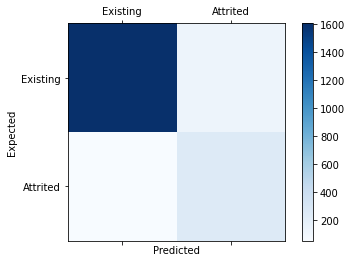

In [23]:
# first test out neighbor = 3 since the the f1 score is the highest

classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

from matplotlib import pyplot as plt

conf_mat = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', conf_mat)


labels = ['Existing', 'Attrited']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()



Confusion matrix:
 [[1563  169]
 [  39  255]]


c:\users\yuezhe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\users\yuezhe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


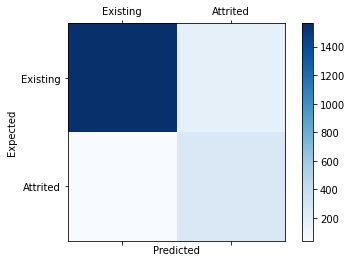

In [24]:
# second, test out when neighbor number = 8

classifier = KNeighborsClassifier(n_neighbors=8)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)


from matplotlib import pyplot as plt

conf_mat = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', conf_mat)


labels = ['Existing', 'Attrited']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()